**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import pairwise_distances
from sklearn.neighbors.kd_tree import KDTree
%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle
from copy import deepcopy


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            # магическая структура строится сама
            # в sklearn leaf_size по-умолчанию 30
            self.tree = KDTree(X, 30, metric='euclidean')
        elif self.algorithm == 'brute':
            self.X = deepcopy(X)

        self.classes = np.unique(y)
        # костыльный перевод, чтобы можно было читерски использовать bincount
        # а потом оказалось, что нечто похожее есть в SupervisedIntegerMixin
        self.class_to_int = {self.classes[i]: i
                             for i in range(self.classes.shape[0])}
        self.int_to_class = {i: self.classes[i]
                             for i in range(self.classes.shape[0])}
        self.y = np.array([self.class_to_int[c] for c in y])

    def predict(self, X):
        if self.algorithm == 'brute':
            X_dist = pairwise_distances(X, self.X, metric='euclidean')

            # argpartition - волшебная функция, выставляет k-ый элемент из
            #                отсортированного порядка на своё место,
            #                меньшие его - в начало, остальные - в конец,
            #                возвращает перестановку элементов
            neighbors_order = np.argpartition(X_dist, self.n_neighbors, axis=1)
            neighbors_order = neighbors_order[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            # магический запрос к магической структуре
            _, neighbors_order = self.tree.query(X, self.n_neighbors)

        neighbors_classes = self.y[neighbors_order]

        # bincount считает количество вхождений целых неотрицательных чисел
        res = [np.bincount(neighbors_classes[i],
                           minlength=self.classes.shape[0])
               for i in range(neighbors_classes.shape[0])]

        return np.array([self.int_to_class[i] for i in np.argmax(res, axis=1)])

    def predict_proba(self, X):
        # наглый копипаст c predict
        if self.algorithm == 'brute':
            X_dist = pairwise_distances(X, self.X, metric='euclidean')

            neighbors_order = np.argpartition(X_dist, self.n_neighbors, axis=1)
            neighbors_order = neighbors_order[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            _, neighbors_order = self.tree.query(X, self.n_neighbors)

        neighbors_classes = self.y[neighbors_order]

        res = [np.bincount(neighbors_classes[i],
                           minlength=self.classes.shape[0])
               for i in range(neighbors_classes.shape[0])]

        res = np.array([res[i] / np.sum(res[i]) for i in range(len(res))])
        return res

    def score(self, X, y):
        y_res = self.predict(X)
        return sum(y_res == y) / y.shape[0]

**IRIS**

In [250]:
iris = datasets.load_iris()

In [251]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [252]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [253]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [254]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [255]:
%time clf.predict(X_test)

Wall time: 1e+03 µs


array([2, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1])

In [256]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([2, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1])

In [257]:
%time clf.predict_proba(X_test)

Wall time: 1e+03 µs


array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [258]:
%time my_clf.predict_proba(X_test)

Wall time: 2 ms


array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [259]:
clf.score(X_test, y_test)

0.93333333333333335

In [260]:
my_clf.score(X_test, y_test)

0.93333333333333335

Задание 3

2513020766
5 : 1.0


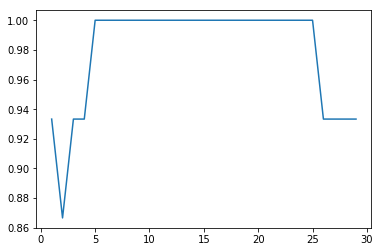

In [284]:
#%%pycodestyle
np.random.seed(2513020613)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

scores = [0] * 30
for i in range(len(scores)):
    my_clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='brute')
    my_clf.fit(X_train, y_train)
    scores[i] = my_clf.score(X_test, y_test)
best = np.argmax(scores)
print(best, ":", scores[best])

# 0 соседей всегда возвращает первый класс, точность сильно ниже
plt.plot(range(1, len(scores)), scores[1:])

# вообще коллекция не очень наглядная, на разных разбиениях очень разные результаты
# иногда бывает постоянно один score, иногда даже везде 1.0

**MNIST**

In [285]:
mnist = fetch_mldata('MNIST original')

In [286]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [287]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [288]:
%time clf.fit(X_train, y_train)

Wall time: 10 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [289]:
%time my_clf.fit(X_train, y_train)

Wall time: 55 ms


In [290]:
%time clf.predict(X_test)

Wall time: 2.63 s


array([ 3.,  9.,  8.,  5.,  1.,  6.,  3.,  4.,  9.,  4.,  6.,  9.,  6.,
        2.,  8.,  9.,  0.,  3.,  3.,  9.,  7.,  0.,  2.,  2.,  9.,  1.,
        5.,  5.,  9.,  9.,  0.,  3.,  7.,  1.,  1.,  9.,  6.,  1.,  0.,
        1.,  2.,  5.,  0.,  5.,  0.,  3.,  2.,  4.,  3.,  0.,  6.,  0.,
        3.,  7.,  6.,  0.,  9.,  7.,  7.,  5.,  3.,  4.,  2.,  4.,  5.,
        4.,  5.,  5.,  5.,  2.,  8.,  3.,  4.,  8.,  4.,  5.,  4.,  6.,
        8.,  8.,  6.,  9.,  3.,  5.,  8.,  4.,  9.,  4.,  3.,  0.,  1.,
        8.,  7.,  3.,  5.,  7.,  3.,  0.,  3.,  8.,  5.,  7.,  0.,  6.,
        8.,  1.,  6.,  8.,  8.,  0.,  4.,  9.,  4.,  7.,  6.,  8.,  2.,
        7.,  6.,  6.,  4.,  1.,  1.,  7.,  9.,  0.,  2.,  1.,  1.,  0.,
        6.,  6.,  1.,  4.,  5.,  7.,  5.,  9.,  9.,  1.,  5.,  3.,  8.,
        5.,  6.,  0.,  5.,  9.,  8.,  7.,  6.,  9.,  4.,  4.,  2.,  0.,
        2.,  6.,  8.,  7.,  4.,  4.,  7.,  7.,  7.,  3.,  8.,  9.,  6.,
        9.,  7.,  1.,  0.,  8.,  8.,  5.,  0.,  0.,  9.,  8.,  1

In [291]:
%time my_clf.predict(X_test)

Wall time: 2.83 s


array([ 3.,  9.,  8.,  5.,  1.,  6.,  3.,  4.,  9.,  4.,  6.,  9.,  6.,
        2.,  8.,  9.,  0.,  3.,  3.,  9.,  7.,  0.,  2.,  2.,  9.,  1.,
        5.,  5.,  9.,  9.,  0.,  3.,  7.,  1.,  1.,  9.,  6.,  1.,  0.,
        1.,  2.,  5.,  0.,  5.,  0.,  3.,  2.,  4.,  3.,  0.,  6.,  0.,
        3.,  7.,  6.,  0.,  9.,  7.,  7.,  5.,  3.,  4.,  2.,  4.,  5.,
        4.,  5.,  5.,  5.,  2.,  8.,  3.,  4.,  8.,  4.,  5.,  4.,  6.,
        8.,  8.,  6.,  9.,  3.,  5.,  8.,  4.,  9.,  4.,  3.,  0.,  1.,
        8.,  7.,  3.,  5.,  7.,  3.,  0.,  3.,  8.,  5.,  7.,  0.,  6.,
        8.,  1.,  6.,  8.,  8.,  0.,  4.,  9.,  4.,  7.,  6.,  8.,  2.,
        7.,  6.,  6.,  4.,  1.,  1.,  7.,  9.,  0.,  2.,  1.,  1.,  0.,
        6.,  6.,  1.,  4.,  5.,  7.,  5.,  9.,  9.,  1.,  5.,  3.,  8.,
        5.,  6.,  0.,  5.,  9.,  8.,  7.,  6.,  9.,  4.,  4.,  2.,  0.,
        2.,  6.,  8.,  7.,  4.,  4.,  7.,  7.,  7.,  3.,  8.,  9.,  6.,
        9.,  7.,  1.,  0.,  8.,  8.,  5.,  0.,  0.,  9.,  8.,  1

In [292]:
%time clf.predict_proba(X_test)

Wall time: 2.56 s


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [293]:
%time my_clf.predict_proba(X_test)

Wall time: 2.9 s


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [294]:
clf.score(X_test, y_test)

0.96999999999999997

In [295]:
my_clf.score(X_test, y_test)

0.96999999999999997

Задание 4

In [296]:
clf = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')

In [297]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [298]:
%time clf.fit(X_train, y_train)

Wall time: 1min 21s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [299]:
%time my_clf.fit(X_train, y_train)

Wall time: 1min 23s


In [300]:
%time clf.predict(X_test)

Wall time: 1min 17s


array([ 3.,  8.,  0.,  4.,  0.,  6.,  1.,  3.,  0.,  8.,  5.,  7.,  1.,
        4.,  0.,  0.,  1.,  5.,  4.,  2.,  7.,  5.,  7.,  3.,  2.,  8.,
        3.,  8.,  6.,  7.,  0.,  1.,  8.,  1.,  7.,  1.,  2.,  6.,  7.,
        2.,  7.,  3.,  2.,  6.,  2.,  7.,  0.,  0.,  8.,  5.,  6.,  2.,
        9.,  9.,  7.,  1.,  7.,  6.,  9.,  2.,  3.,  7.,  0.,  6.,  7.,
        2.,  0.,  4.,  0.,  6.,  4.,  2.,  5.,  8.,  0.,  1.,  5.,  2.,
        4.,  1.,  7.,  4.,  2.,  0.,  8.,  9.,  6.,  7.,  5.,  3.,  0.,
        0.,  9.,  5.,  2.,  9.,  1.,  8.,  4.,  7.,  3.,  7.,  5.,  0.,
        4.,  9.,  4.,  8.,  4.,  7.,  6.,  1.,  0.,  6.,  5.,  6.,  4.,
        1.,  5.,  1.,  2.,  5.,  6.,  5.,  3.,  3.,  0.,  6.,  7.,  2.,
        3.,  7.,  7.,  9.,  9.,  7.,  0.,  6.,  8.,  7.,  8.,  5.,  2.,
        5.,  6.,  2.,  6.,  2.,  7.,  9.,  0.,  5.,  0.,  0.,  3.,  0.,
        3.,  3.,  3.,  0.,  7.,  9.,  8.,  8.,  0.,  2.,  4.,  7.,  4.,
        1.,  9.,  9.,  6.,  8.,  5.,  7.,  2.,  5.,  1.,  8.,  4

In [301]:
%time my_clf.predict(X_test)

Wall time: 1min 18s


array([ 3.,  8.,  0.,  4.,  0.,  6.,  1.,  3.,  0.,  8.,  5.,  7.,  1.,
        4.,  0.,  0.,  1.,  5.,  4.,  2.,  7.,  5.,  7.,  3.,  2.,  8.,
        3.,  8.,  6.,  7.,  0.,  1.,  8.,  1.,  7.,  1.,  2.,  6.,  7.,
        2.,  7.,  3.,  2.,  6.,  2.,  7.,  0.,  0.,  8.,  5.,  6.,  2.,
        9.,  9.,  7.,  1.,  7.,  6.,  9.,  2.,  3.,  7.,  0.,  6.,  7.,
        2.,  0.,  4.,  0.,  6.,  4.,  2.,  5.,  8.,  0.,  1.,  5.,  2.,
        4.,  1.,  7.,  4.,  2.,  0.,  8.,  9.,  6.,  7.,  5.,  3.,  0.,
        0.,  9.,  5.,  2.,  9.,  1.,  8.,  4.,  7.,  3.,  7.,  5.,  0.,
        4.,  9.,  4.,  8.,  4.,  7.,  6.,  1.,  0.,  6.,  5.,  6.,  4.,
        1.,  5.,  1.,  2.,  5.,  6.,  5.,  3.,  3.,  0.,  6.,  7.,  2.,
        3.,  7.,  7.,  9.,  9.,  7.,  0.,  6.,  8.,  7.,  8.,  5.,  2.,
        5.,  6.,  2.,  6.,  2.,  7.,  9.,  0.,  5.,  0.,  0.,  3.,  0.,
        3.,  3.,  3.,  0.,  7.,  9.,  8.,  8.,  0.,  2.,  4.,  7.,  4.,
        1.,  9.,  9.,  6.,  8.,  5.,  7.,  2.,  5.,  1.,  8.,  4

In [302]:
%time clf.predict_proba(X_test)

Wall time: 1min 20s


array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0.6,  0.4],
       [ 1. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [303]:
%time my_clf.predict_proba(X_test)

Wall time: 1min 17s


array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0.6,  0.4],
       [ 1. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [304]:
clf.score(X_test, y_test)

0.97142857142857142

In [305]:
my_clf.score(X_test, y_test)

0.97142857142857142

Задание 5

In [ ]:
# seaborn
    рисовать красивые графики
# matplotlib
    рисовать чуть менее красивые графики
# train_test_split
    разбить выборку на 2 части: для обучения и для проверки качества
# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
    #просто Pipeline (from sklearn.pipeline import Pipeline)?
    позволяет применять композицию трансформаций к features перед применением алгоритма обучения,
    то есть что-то типа конвейера/композиции функций
# StandardScaler (from sklearn.preprocessing import StandardScaler)
    приводит feature к "стандартному" распределению с нулевым матожиданием и единичной дисперсией
    (сдвиг на -матожидание + масштабирование на корень из дисперсии)
    
mixin - специальный класс, функции которого могут использовать другие классы,
        не обязательно наследники (чтобы избежать неоднозначностей при множественном наследовании)
        (хотя здесь они всё равно почти все наследуются)
# ClassifierMixin
    базовый класс для оценочных функций, содержит только функцию score
# NeighborsBase
    базовый класс для оценочных функций по методу ближайших соседей,
    содержит функцию для инициализации параметров и базовый _fit для построения модели 
                                                (складывает выборку в соответствующую алгоритму структуру)
# KNeighborsMixin
    базовый класс для классификаторов по методу k ближайших соседей
    содержит функции для получения k ближайших соседей без весов и с весами
# SupervisedIntegerMixin
    базовый класс для обучения с учителем (оценка целочисленной переменной ~ классификация)
    содержит функцию fit, которая подготавливает входные данные и вызывает (видимо отнаследованный) _fit